# Social Network Ad based Predictions

## Setting up the environment

In [88]:
import pandas as pd
df = pd.read_csv('../Social-Network-Ads/Social_Network_Ads.csv')
# check for number of null entries
print('Data is packed' if not df.isnull().values.any() else 'Data contains missing values')
df.head()

Data is packed


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


<Figure size 432x288 with 0 Axes>

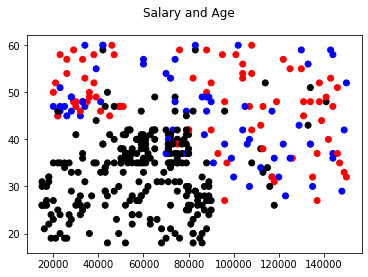

In [89]:
# Visualizing the data
import matplotlib.pyplot as plt

# Age vs salary. Men are blue points, Females are Red points and No Buyers are black points
salaries = df['EstimatedSalary']
ages = df['Age']
genders = df['Gender']
buy_stats = df['Purchased']
colors = ['blue' if genders[i] == 'Male' and buy_stats[i] == 1 else 'red' if genders[i] == 'Female' and buy_stats[i] == 1 else 'black' for i in range(len(df['User ID'].tolist()))]
plt.clf()
fig = plt.figure()
fig.suptitle("Salary and Age")
plt.scatter(salaries, ages, c = colors)

## Preprocessing the data

### Data Cleaning and Scaling

In [90]:
# User ID is irrelevant
df = df.drop(['User ID'], axis = 1)

# We can change Male and Female to 0 or 1
df['Gender'] = df['Gender'].apply(lambda gender: 0 if gender == 'Male' else 1)

# Normalize Age and EstimatedSalary based on mean and range
# value = (val - mean)/(max - min)

# Salary Normalization
import math
salaries = df['EstimatedSalary']
mean_salary = min(salaries) + max(salaries) / len(salaries)
salary_range = max(salaries) - min(salaries)
norm_salaries = [(salary - mean_salary) / salary_range for salary in salaries]

# Age normalization
ages = df['Age']
mean_age = min(ages) + max(ages) / len(ages)
age_range = max(ages) - min(ages)
norm_ages = [(age - mean_age) / age_range for age in ages]

# Assign to df
df['Age'] = norm_ages
df['EstimatedSalary'] = norm_salaries
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,0,0.020238,0.026852,0
1,0,0.401190,0.034259,0
2,1,0.186905,0.204630,0
3,1,0.210714,0.308333,0
4,0,0.020238,0.449074,0


### Train and Test split

In [91]:
# Use 60% data as training data and 20% as validation data and 20% as test data
y = df.pop('Purchased').to_numpy()
X = df.to_numpy()

# Split
from sklearn.model_selection import train_test_split

# Train+Validation and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Train and Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)

In [92]:
print(f'''Training size: {len(X_train)}
Validation size: {len(X_valid)}
Test size: {len(X_test)}''')

Training size: 240
Validation size: 80
Test size: 80


# Creating Keras Model

In [229]:
from tensorflow import keras

#ANN
model = keras.Sequential()
model.add(keras.layers.Dense(int(X_train.shape[1]*2), input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(X_train.shape[1]*2, activation = 'relu'))
model.add(keras.layers.Dense(X_train.shape[1]*2, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
print(model.summary())

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 6)                 24        
_________________________________________________________________
dense_176 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_177 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_178 (Dense)            (None, 1)                 7         
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
None


In [230]:
#Set epochs
epochs = 100

#Fit the model
trained_model = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_valid, y_valid))

Epoch 1/100
8/8 [==============================] - 0s 24ms/step - loss: 0.6984 - accuracy: 0.4042 - val_loss: 0.7361 - val_accuracy: 0.2625
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.6888 - accuracy: 0.4167 - val_loss: 0.7183 - val_accuracy: 0.3000
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 0.6773 - accuracy: 0.4458 - val_loss: 0.6986 - val_accuracy: 0.3875
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 0.6644 - accuracy: 0.5292 - val_loss: 0.6771 - val_accuracy: 0.5375
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6504 - accuracy: 0.6708 - val_loss: 0.6544 - val_accuracy: 0.6500
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.6356 - accuracy: 0.7042 - val_loss: 0.6293 - val_accuracy: 0.6500
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 0.6215 - accuracy: 0.7417 - val_loss: 0.6060 - val_accuracy: 0.6750
Epoch 8/100
8/8 [========

8/8 [==============================] - 0s 5ms/step - loss: 0.2643 - accuracy: 0.9167 - val_loss: 0.4339 - val_accuracy: 0.8125
Epoch 60/100
8/8 [==============================] - 0s 7ms/step - loss: 0.2621 - accuracy: 0.9125 - val_loss: 0.4349 - val_accuracy: 0.8125
Epoch 61/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2601 - accuracy: 0.9167 - val_loss: 0.4401 - val_accuracy: 0.8125
Epoch 62/100
8/8 [==============================] - 0s 5ms/step - loss: 0.2595 - accuracy: 0.9167 - val_loss: 0.4345 - val_accuracy: 0.8125
Epoch 63/100
8/8 [==============================] - 0s 5ms/step - loss: 0.2578 - accuracy: 0.9208 - val_loss: 0.4457 - val_accuracy: 0.8125
Epoch 64/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2557 - accuracy: 0.9208 - val_loss: 0.4390 - val_accuracy: 0.8125
Epoch 65/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2523 - accuracy: 0.9208 - val_loss: 0.4379 - val_accuracy: 0.8125
Epoch 66/100
8/8 [===============

Max Accuracy Reached: 93.33 %


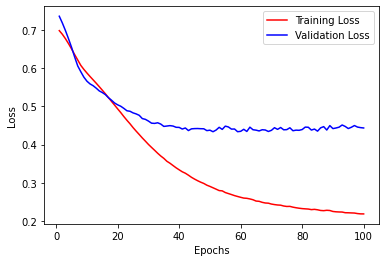

In [249]:
print('Max Accuracy Reached: {0:0.2f} %'.format((max(trained_model.history['accuracy']) * 100)) )
# Print the learning curve
plt.plot(range(1, epochs+1), trained_model.history['loss'] , 'r', range(1, epochs+1), trained_model.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

# Making Predictions

In [243]:
predictions = model.predict(X_test)
from sklearn.metrics import accuracy_score
predictions = [0 if prob < 0.5 else 1 for prob in predictions]
print("Test Set Accuracy: {0:0.2f} %".format(accuracy_score(y_test, predictions) * 100))

Test Set Accuracy: 91.25 %
